In [655]:
#load libraries
from datetime import datetime, timedelta
from dateutil import parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv, os
from glob import glob
#Import scikit-learn dataset library
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.datasets import dump_svmlight_file
from random import shuffle


#load the data
PATH = "/Users/leeo/Desktop/KI2/7.master_thesis/1.data/13.deal_withi_overfitting/combine_fe_8/training_data_undersample_binary.csv"
df = pd.read_csv(PATH, sep=",", header=0,
                       parse_dates=[0], index_col=0)
#add coefficient of variance
df["cv"] = df["std"]/df["mean"]
df["cv.1"] = df["std.1"]/df["mean.1"]
cols = df.columns.tolist()
cols = cols[-2:] + cols[:-2]
df = df[cols]

In [574]:
X = df.loc[:, ['cv', 'cv.1', 'amplitude', 'amplitude.1', 
       'mean', 'mean.1', 'maximum', 'maximum.1', 'median', 'median.1',
       'minimum', 'minimum.1', 'skew', 'skew.1', 'std', 'std.1',
       'median_absolute_deviation', 'median_absolute_deviation.1',
       'percent_beyond_1_std',
       'percent_beyond_1_std.1', 'percent_close_to_median',
       'percent_close_to_median.1', 'qso_log_chi2_qsonu',
        'stetson_j', 'stetson_j.1', 'stetson_k',
       'stetson_k.1', 'weighted_average', 'weighted_average.1']]

In [656]:
# Split the training and testing dataseet
#df = shuffle(df,random_state=42)
X=df[df.columns[:-2]]  # Features
y=df[df.columns[-2]]  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 70% training and 30% test
#df.iloc[X_test.index]["label"].value_counts()
#df.iloc[X_train.index]["label"].value_counts()

# Random forest

In [657]:
#Create a RF Classifier
clf=RandomForestClassifier(n_estimators=20)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

#apply the model
y_pred=clf.predict(X_test)

# Model Accuracy, Precisiono and recall
print("Confusion matrix:\n",metrics.confusion_matrix(y_test, y_pred))
print("Accuracy",metrics.accuracy_score(y_test, y_pred))
print("Classification_report:\n",metrics.classification_report(y_test, y_pred))


#Train the model using the entire training sets 
#clf.fit(X,y)


Confusion matrix:
 [[5618  324]
 [ 501 2522]]
Accuracy 0.9079754601226994
Classification_report:
               precision    recall  f1-score   support

         0.0       0.92      0.95      0.93      5942
         1.0       0.89      0.83      0.86      3023

    accuracy                           0.91      8965
   macro avg       0.90      0.89      0.90      8965
weighted avg       0.91      0.91      0.91      8965



In [582]:
# Calculate feature importances
importances = clf.fit(X,y).feature_importances_

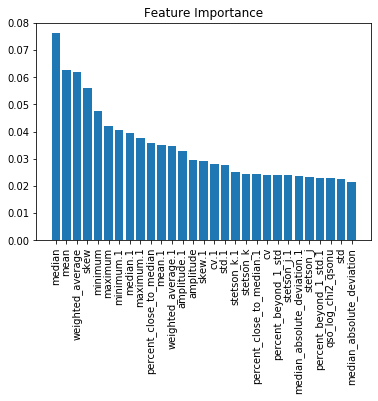

In [587]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

# XGBoost

In [164]:
# use DMatrix for xgbosot
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


# use svmlight file for xgboost
dump_svmlight_file(X_train, y_train, 'dtrain.svm', zero_based=True)
dump_svmlight_file(X_test, y_test, 'dtest.svm', zero_based=True)
dtrain_svm = xgb.DMatrix('dtrain.svm')
dtest_svm = xgb.DMatrix('dtest.svm')

# set xgboost params
param = {
    'max_depth': 6,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 10  # the number of training iterations

/anaconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[22:10:08] 21711x18 matrix with 390798 entries loaded from dtrain.svm
[22:10:08] 9306x18 matrix with 167508 entries loaded from dtest.svm


In [165]:
# training and testing - numpy matrices
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

#model evaluation: Model Accuracy, Precisiono and recall
print("Confusion matrix:\n",metrics.confusion_matrix(y_test, best_preds))
print("Accuracy",metrics.accuracy_score(y_test, best_preds))
print("Classification_report:\n",metrics.classification_report(y_test, best_preds))

Confusion matrix:
 [[5585  606]
 [1317 1798]]
Accuracy 0.7933591231463571
Classification_report:
               precision    recall  f1-score   support

         0.0       0.81      0.90      0.85      6191
         1.0       0.75      0.58      0.65      3115

    accuracy                           0.79      9306
   macro avg       0.78      0.74      0.75      9306
weighted avg       0.79      0.79      0.79      9306



## Support Vector Machine
* The running time is approximately 2h

In [ ]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

#apply the model
y_pred = svclassifier.predict(X_test)

# Model Accuracy, Precisiono and recall
print("Confusion matrix:\n",metrics.confusion_matrix(y_test, y_pred))
print("Accuracy",metrics.accuracy_score(y_test, y_pred))
print("Classification_report:\n",metrics.classification_report(y_test, y_pred))

# Logistic Regression

In [267]:
#train the model
model = LogisticRegression(solver='saga', multi_class="multinomial",random_state=42).fit(X_train, y_train)

#apply the model
y_pred=model.predict(X_test)

# Model Accuracy, Precisiono and recall
print("Confusion matrix:\n",metrics.confusion_matrix(y_test, y_pred))
print("Accuracy",metrics.accuracy_score(y_test, y_pred))
print("Classification_report:\n",metrics.classification_report(y_test, y_pred))

Confusion matrix:
 [[2314  862   43]
 [ 955 1453   39]
 [ 243  416  109]]
Accuracy 0.6024246192104445
Classification_report:
               precision    recall  f1-score   support

         0.0       0.66      0.72      0.69      3219
         1.0       0.53      0.59      0.56      2447
         2.0       0.57      0.14      0.23       768

    accuracy                           0.60      6434
   macro avg       0.59      0.48      0.49      6434
weighted avg       0.60      0.60      0.58      6434



/anaconda3/envs/p3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


# External evaluation

In [653]:
PATH = "/Users/leeo/Desktop/KI2/7.master_thesis/1.data/13.deal_withi_overfitting/combine_fe_8/testing_data_binary.csv"
dftest = pd.read_csv(PATH, sep=",", header=0,
                       parse_dates=[0], index_col=0)

#add coefficient of variance
dftest["cv"] = dftest["std"]/dftest["mean"]
dftest["cv.1"] = dftest["std.1"]/dftest["mean.1"]
cols = dftest.columns.tolist()
cols = cols[-2:] + cols[:-2]
dftest = dftest[cols]


X_test=dftest[dftest.columns[:-2]]  # Features
y_test=dftest[dftest.columns[-2]]  # Labels

In [578]:
X_test= dftest.loc[:, ['cv', 'cv.1', 'amplitude', 'amplitude.1', 
       'mean', 'mean.1', 'maximum', 'maximum.1', 'median', 'median.1',
       'minimum', 'minimum.1', 'skew', 'skew.1', 'std', 'std.1',
       'median_absolute_deviation', 'median_absolute_deviation.1',
       'percent_beyond_1_std',
       'percent_beyond_1_std.1', 'percent_close_to_median',
       'percent_close_to_median.1',  'qso_log_chi2_qsonu',
       'stetson_j', 'stetson_j.1', 'stetson_k',
       'stetson_k.1', 'weighted_average', 'weighted_average.1']]

In [579]:
X_test.min()<-10000

cv                             False
cv.1                           False
amplitude                      False
amplitude.1                    False
mean                           False
mean.1                         False
maximum                        False
maximum.1                      False
median                         False
median.1                       False
minimum                        False
minimum.1                      False
skew                           False
skew.1                         False
std                            False
std.1                          False
median_absolute_deviation      False
median_absolute_deviation.1    False
percent_beyond_1_std           False
percent_beyond_1_std.1         False
percent_close_to_median        False
percent_close_to_median.1      False
qso_log_chi2_qsonu             False
stetson_j                      False
stetson_j.1                    False
stetson_k                      False
stetson_k.1                    False
w

In [532]:
np.where(np.isnan(X_test)) 

(array([], dtype=int64), array([], dtype=int64))

In [533]:
X_test.fillna(method='ffill', inplace =True)

In [534]:
X_test = X_test.dropna()

In [654]:
#RF
#apply the model
y_pred=clf.predict(X_test)

# Model Accuracy, Precisiono and recall
print("Confusion matrix:\n",metrics.confusion_matrix(y_test, y_pred))
print("Accuracy",metrics.accuracy_score(y_test, y_pred))
print("Classification_report:\n",metrics.classification_report(y_test, y_pred))

Confusion matrix:
 [[22959  4100]
 [ 2049  2116]]
Accuracy 0.803068152703049
Classification_report:
               precision    recall  f1-score   support

         0.0       0.92      0.85      0.88     27059
         1.0       0.34      0.51      0.41      4165

    accuracy                           0.80     31224
   macro avg       0.63      0.68      0.64     31224
weighted avg       0.84      0.80      0.82     31224



In [104]:
# use DMatrix for xgbosot
dtest = xgb.DMatrix(X_test, label=y_test)


# use svmlight file for xgboost
dump_svmlight_file(X_test, y_test, 'dtest.svm', zero_based=True)
dtest_svm = xgb.DMatrix('dtest.svm')

# set xgboost params
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3}  # the number of classes that exist in this datset
num_round = 10  # the number of training iterations

/anaconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/anaconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[01:45:11] 30795x16 matrix with 492720 entries loaded from dtest.svm


In [105]:
# training and testing - numpy matrices
preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

#model evaluation: Model Accuracy, Precisiono and recall
print("Confusion matrix:\n",metrics.confusion_matrix(y_test, best_preds))
print("Accuracy",metrics.accuracy_score(y_test, best_preds))
print("Classification_report:\n",metrics.classification_report(y_test, best_preds))

Confusion matrix:
 [[20444  5372   794]
 [ 1151  1283   119]
 [  394  1144    94]]
Accuracy 0.708589056665043
Classification_report:
               precision    recall  f1-score   support

         0.0       0.93      0.77      0.84     26610
         1.0       0.16      0.50      0.25      2553
         2.0       0.09      0.06      0.07      1632

    accuracy                           0.71     30795
   macro avg       0.40      0.44      0.39     30795
weighted avg       0.82      0.71      0.75     30795



# recombine data with more features

In [625]:
PATH = "/Users/leeo/Desktop/KI2/7.master_thesis/1.data/17.more_feature_label_10min/lps_saline_fe/"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]

In [626]:
combined_data = []
for f in all_csv_files:
    data = pd.read_csv(f, sep=",", header=0,
                   parse_dates=[0], index_col=0)
    data["AnimalID"]=int(f[-9:-4])
    # store DataFrame in list
    combined_data.append(data)
combined_data = pd.concat(combined_data)
combined_data["label"].value_counts()

0.0    70846
Name: label, dtype: int64

In [627]:
print(combined_data.columns)
combined_data.head()

Index(['amplitude', 'amplitude.1', 'max_slope', 'max_slope.1', 'mean',
       'mean.1', 'maximum', 'maximum.1', 'median', 'median.1', 'minimum',
       'minimum.1', 'skew', 'skew.1', 'std', 'std.1',
       'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid20.1',
       'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid35.1',
       'flux_percentile_ratio_mid50', 'flux_percentile_ratio_mid50.1',
       'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid65.1',
       'flux_percentile_ratio_mid80', 'flux_percentile_ratio_mid80.1',
       'median_absolute_deviation', 'median_absolute_deviation.1',
       'percent_amplitude', 'percent_amplitude.1', 'percent_beyond_1_std',
       'percent_beyond_1_std.1', 'percent_close_to_median',
       'percent_close_to_median.1', 'percent_difference_flux_percentile',
       'percent_difference_flux_percentile.1', 'qso_log_chi2_qsonu',
       'qso_log_chi2_qsonu.1', 'stetson_j', 'stetson_j.1', 'stetson_k',
       'stetson_k.1', 'weight

,amplitude,amplitude.1,max_slope,max_slope.1,mean,mean.1,maximum,maximum.1,median,median.1,minimum,minimum.1,skew,skew.1,std,std.1,flux_percentile_ratio_mid20,flux_percentile_ratio_mid20.1,flux_percentile_ratio_mid35,flux_percentile_ratio_mid35.1,flux_percentile_ratio_mid50,flux_percentile_ratio_mid50.1,flux_percentile_ratio_mid65,flux_percentile_ratio_mid65.1,flux_percentile_ratio_mid80,flux_percentile_ratio_mid80.1,median_absolute_deviation,median_absolute_deviation.1,percent_amplitude,percent_amplitude.1,percent_beyond_1_std,percent_beyond_1_std.1,percent_close_to_median,percent_close_to_median.1,percent_difference_flux_percentile,percent_difference_flux_percentile.1,qso_log_chi2_qsonu,qso_log_chi2_qsonu.1,stetson_j,stetson_j.1,stetson_k,stetson_k.1,weighted_average,weighted_average.1,start_time,end_time,label,AnimalID
feature,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
channel,0.000000,1.000000,0.000000e+00,1.000000e+00,0.000000,1.000000,0.0000,1.000000,0.00000,1.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.0000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,18273
0,51.813675,4.311116,3.792480e-08,5.623065e-09,121.711396,0.857965,189.7301,6.008276,116.39075,0.719275,86.10275,-2.613956,0.791889,1.254870,18.539590,0.851054,9.209011e-07,0.174496,0.000008,0.327211,0.000049,0.469752,0.000992,0.639781,0.017831,0.845323,12.8473,0.493853,1.302776e+12,20.542314,0.310833,0.249167,0.430000,0.796667,4.206813e+07,1.965411,9.250848,3.088470,150.102301,6.022791,0.959551,0.896576,121.711396,0.857965,2018-11-23 13:35:33.640570,2018-11-23 13:45:33.640570,0.0,18273
1,40.914125,4.311116,3.792480e-08,5.623065e-09,117.490006,0.822269,167.9310,6.008276,113.97215,0.699203,86.10275,-2.613956,0.414415,1.247098,14.281150,0.798566,3.464370e-06,0.168810,0.000017,0.323945,0.000099,0.474442,0.001495,0.646629,0.017831,0.851191,9.0248,0.483462,1.405184e+11,20.147719,0.365833,0.255833,0.471667,0.809167,4.537502e+06,1.869525,8.728912,2.961156,116.301371,5.633078,0.972135,0.904674,117.490006,0.822269,2018-11-23 13:36:33.640570,2018-11-23 13:46:33.640570,0.0,18273
2,45.142925,4.311116,3.792480e-08,5.623065e-09,117.739714,0.833094,176.3886,6.008276,113.97215,0.725558,86.10275,-2.613956,0.815078,1.204496,15.281734,0.800085,3.464370e-06,0.176602,0.000017,0.325905,0.000099,0.482175,0.001495,0.648436,0.017831,0.851117,8.9223,0.494507,1.405184e+11,20.667314,0.295833,0.264167,0.503333,0.804167,4.537502e+06,1.915459,8.864347,2.964957,118.787596,5.701626,0.929419,0.914746,117.739714,0.833094,2018-11-23 13:37:33.640570,2018-11-23 13:47:33.640570,0.0,18273
3,45.142925,3.722035,3.792480e-08,5.623065e-09,118.713991,0.807083,176.3886,4.830114,114.24500,0.768526,86.10275,-2.613956,0.723899,0.521320,16.199469,0.715808,3.061918e-06,0.190250,0.000015,0.336209,0.000101,0.481375,0.001495,0.649868,0.017831,0.856301,9.7194,0.484814,1.802129e+11,21.541953,0.305000,0.305000,0.479167,0.735833,5.819284e+06,1.936863,8.980988,2.742345,128.181092,5.379855,0.934358,0.979755,118.713991,0.807083,2018-11-23 13:38:33.640570,2018-11-23 13:48:33.640570,0.0,18273


In [628]:
combined_data = combined_data.drop(columns="start_time")
combined_data = combined_data.drop(columns="end_time")
combined_data = combined_data.drop("channel")
#combined_data = combined_data.drop(["channel","4104"])
df = combined_data.reset_index(drop=True)
df["AnimalID"].value_counts()

18248    12368
18231    10156
18233    10002
18284     9739
18273     9736
17273     9500
18251     9345
Name: AnimalID, dtype: int64

In [629]:
#export the data
exf=PATH+"lps_saline_groups.csv"
df.to_csv(exf, header=True)
print("The data have been exported to {}.".format(exf))

The data have been exported to /Users/leeo/Desktop/KI2/7.master_thesis/1.data/17.more_feature_label_10min/lps_saline_fe/lps_saline_groups.csv.


In [611]:
data1 = pd.read_csv("/Users/leeo/Desktop/KI2/7.master_thesis/1.data/17.more_feature_label_10min/combine_fe/lps_saline_groups.csv", sep=",", header=0,
                   parse_dates=[0], index_col=0)


In [612]:
data2 = pd.read_csv("/Users/leeo/Desktop/KI2/7.master_thesis/1.data/12.feature_label_8h_control/lps_saline_fe/lps_saline_group.csv", sep=",", header=0,
                   parse_dates=[0], index_col=0)


In [379]:
data1["label"] =  data2 ["label"]

In [599]:
tmp = data1["label"]  - data2 ["label"]

In [600]:
sum(tmp)

nan

In [382]:
data1.to_csv("/Users/leeo/Desktop/KI2/7.master_thesis/1.data/16.more_feature_label_5min/combine_fe/lps_saline.csv", header=True)

In [613]:
data1["AnimalID"].value_counts()

18248    12368
18231    10156
18233    10002
18284     9739
18273     9736
17273     9500
18251     9345
Name: AnimalID, dtype: int64

In [614]:
data2["AnimalID"].value_counts()

18248    12367
18231    10155
18233    10001
18284     9738
18273     9735
17273     9499
18251     9344
Name: AnimalID, dtype: int64

In [632]:
tmp = data1[data1["AnimalID"]==18273]-data2[data2["AnimalID"] ==18273]
tmp

,AnimalID,amplitude,amplitude.1,flux_percentile_ratio_mid20,flux_percentile_ratio_mid20.1,flux_percentile_ratio_mid35,flux_percentile_ratio_mid35.1,flux_percentile_ratio_mid50,flux_percentile_ratio_mid50.1,flux_percentile_ratio_mid65,flux_percentile_ratio_mid65.1,flux_percentile_ratio_mid80,flux_percentile_ratio_mid80.1,label,max_slope,max_slope.1,maximum,maximum.1,mean,mean.1,median,median.1,median_absolute_deviation,median_absolute_deviation.1,minimum,minimum.1,percent_amplitude,percent_amplitude.1,percent_beyond_1_std,percent_beyond_1_std.1,percent_close_to_median,percent_close_to_median.1,percent_difference_flux_percentile,percent_difference_flux_percentile.1,qso_log_chi2_qsonu,qso_log_chi2_qsonu.1,skew,skew.1,std,std.1,stetson_j,stetson_j.1,stetson_k,stetson_k.1,weighted_average,weighted_average.1
0,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000e+00,0.000000e+00,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,NaN,NaN,0.00000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [646]:
sum(tmp['amplitude']>4)

600